# Accessors for WSIData

The accessor is a concept that use attributes to extend the capabilities of a class.

There are three in-built accessors in the WSIData class:

- {py:class}`fetch <wsidata.FetchAccessor>`: Fetch information about the WSI
- {py:class}`iter <wsidata.IterAccessor>`: Iterate over the content of the WSI
- {py:class}`ds <wsidata.DatasetAccessor>`: Create deep learning datasets from the WSI

Here, we will load a WSI that have already been processed with tissue detection, tissue tiling, and feature extraction.

In your case, you can easily run these steps with `LazySlide` package.

In [1]:
from wsidata import open_wsi

wsi = open_wsi("CMU-1-Small-Region.svs")

## Fetch accessor

In [2]:
wsi.fetch.pyramids()

,height,width,downsample
level,,,
0,2967,2220,1.0


In [3]:
wsi.fetch.features_anndata("resnet50")

AnnData object with n_obs × n_vars = 31 × 1000
    obs: 'id', 'x', 'y', 'tissue_id'
    uns: 'tile_spec', 'slide_properties'
    obsm: 'spatial'

## Iter accessor

Information from iter accessor will always be a data container.

Iterate through tissue contours

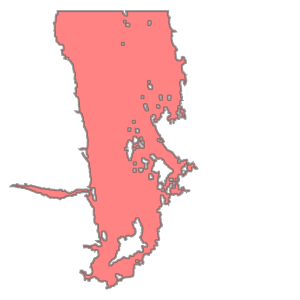

In [4]:
d = next(wsi.iter.tissue_contours("tissues"))
d.contour

You can use a for loop to iterate every tissue

In [5]:
for d in wsi.iter.tissue_contours("tissues"):
    d.contour

Iterate through tissue images

In [6]:
no_mask = next(wsi.iter.tissue_images("tissues"))
with_mask = next(wsi.iter.tissue_images("tissues", mask_bg=True))
color_norm = next(wsi.iter.tissue_images("tissues", color_norm="macenko"))

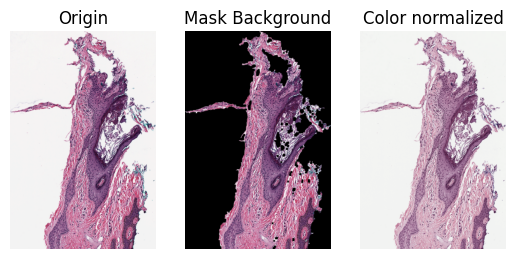

In [7]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(ncols=3)
for ax, d, title in zip(
    axes,
    [no_mask, with_mask, color_norm],
    ["Origin", "Mask Background", "Color normalized"],
):
    ax.set_axis_off()
    ax.imshow(d.image)
    ax.set_title(title)

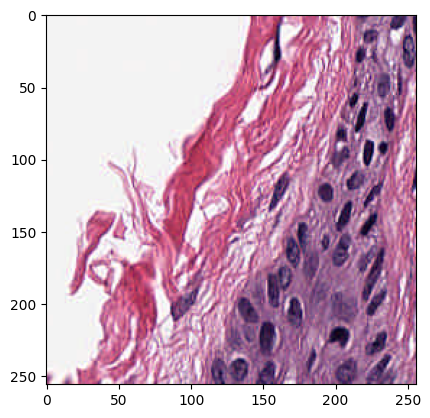

In [8]:
d = next(wsi.iter.tile_images("tiles"))
plt.imshow(d.image)

## Dataset accessor

In [9]:
dataset = wsi.ds.tile_images()

The dataset is a torch dataset that can be used to train a deep learning model. You can load it in the DataLoader and train the model.

In [10]:
from torch.utils.data import DataLoader

dl = DataLoader(dataset, batch_size=36, shuffle=True)